In [49]:
import torch
import torch.utils
from torchvision import datasets, transforms
import torchvision.utils
import numpy as np
import matplotlib.pyplot as plt

In [51]:
n_g = 1  # size of the latent gaussian variable
n_b = 4  # size of the latent binary variable
n_o = 0  # size of the latent one-hot variable

batch_size = 64  # samples of data distribution at each iteration
latent_batch_size = np.power(32, n_g) * np.power(2, n_b) * max(1, n_o)  # number of possible latent codes to try for each sample

n_epochs = 300

In [52]:
use_cuda = torch.cuda.is_available()
gpu_id = 5
device = torch.device("cuda:5" if use_cuda else "cpu")

torch.manual_seed(42)
np.random.seed(42)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [53]:
class LatentCodeDistribution():
    def __init__(self, n_g, n_b, n_o):
        self.m_n = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n_g), torch.eye(n_g))
        self.m_b = torch.distributions.bernoulli.Bernoulli(torch.tensor([0.5]))
        self.m_o = torch.distributions.one_hot_categorical.OneHotCategorical(torch.ones(n_o)/n_o)
        
        self.n_g, self.n_b, self.n_o = n_g, n_b, n_o
        
    def sample(self, n_samples):
        gaussian_samples = self.m_n.sample([n_samples],)
        bernoulli_samples = self.m_b.sample([n_samples, self.n_b]).squeeze(-1)  # there is a singleton dimension that has to be removed
        one_hot_samples = self.m_o.sample([n_samples]) if self.n_o != 0 else torch.zeros([n_samples, 0])
        
        return torch.cat([gaussian_samples, bernoulli_samples, one_hot_samples], dim=1)

In [54]:
# D_in is input dimension;
# H is hidden dimension;
# D_out is output dimension.

D_in, H, D_out = n_g + n_b + n_o, 100, 28 * 28

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
).to(device)

In [55]:
def row_wise_repeat(mat, n_rep):
    """
    pytorch equivalent of np.repeat
    """
    return torch.cat([row.repeat(n_rep, 1) for row in mat.split(split_size=1)])

In [56]:
params = list(model.parameters())
    
optimizer = torch.optim.Adam(params, betas=(0.5, 0.999))
loss_fn = torch.nn.L1Loss(reduction='none')

In [74]:
loss_log = []
latent_code_dist = LatentCodeDistribution(n_g, n_b, n_o)

for epoch in range(1, n_epochs + 1):
    current_epoch_losses = []
    
    for batch_idx, (data, _) in enumerate(train_loader):
        if batch_idx % 100 == 0:
            print('Iteration: {}'.format(batch_idx))
        data = data.to(device) 
        data = data.reshape(data.shape[0], -1)  # flatten the image
        
        x_train = latent_code_dist.sample(latent_batch_size).to(device)
        y_train = data.repeat(latent_batch_size, 1)
        
        y_pred = row_wise_repeat(model(x_train), batch_size)

        loss_all_modes = loss_fn(y_pred, y_train)
        

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()
        
        selective_loss = loss_all_modes.mean(dim=1).reshape(latent_batch_size, batch_size).min(dim=0)[0].sum()
        selective_loss.backward()        
        
        current_epoch_losses.append(selective_loss)
        
        optimizer.step()
    
    loss_log.append(torch.tensor(current_epoch_losses).mean().detach().numpy())
    
    if True:  # if epoch % 10 == 0:
        print('Epoch: {} / Loss: {:.2f}'.format(epoch, loss_log[-1]) + '\n' + '=' * 23)

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 1 / Loss: 16.65
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 2 / Loss: 16.64
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 3 / Loss: 16.63
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 4 / Loss: 16.62
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 5 / Loss: 16.61
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 9

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 43 / Loss: 16.40
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 44 / Loss: 16.39
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 45 / Loss: 16.39
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 46 / Loss: 16.38
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 47 / Loss: 16.38
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iterati

Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 85 / Loss: 16.31
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 86 / Loss: 16.31
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 87 / Loss: 16.31
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 88 / Loss: 16.31
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 89 / Loss: 16.30
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch

KeyboardInterrupt: 

In [ ]:
data.repeat(latent_batch_size, 1).shape

In [ ]:
latent_code_dist.sample(10)

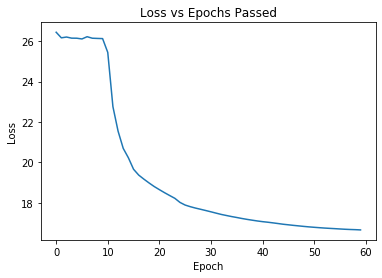

In [58]:
plt.figure()
plt.title('Loss vs Epochs Passed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_log)), loss_log)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


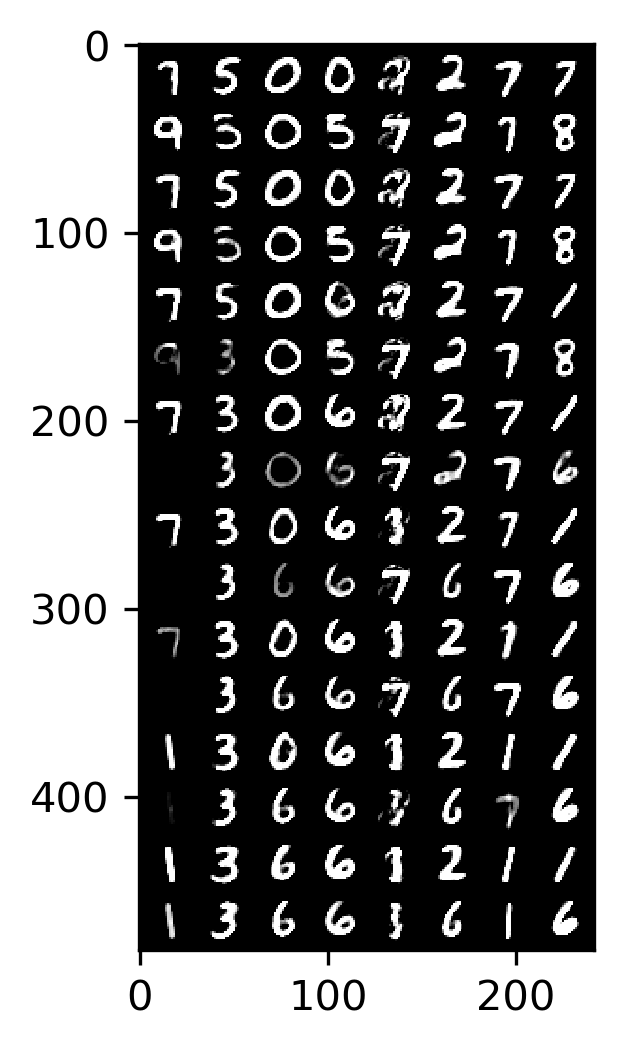

In [75]:
from scipy.stats import norm
import itertools

grid_width = 8

if n_g == 2 and n_b == 0 and n_o == 0:
    x1 = np.linspace(0.02, 0.98, grid_width)
    x2 = np.linspace(0.02, 0.98, grid_width)
    x1, x2 = norm.ppf(x1), norm.ppf(x2)  # apply inverse normal cdf to distribute codes equally across the distribution

    xv1, xv2 = np.meshgrid(x1, x2)
    
    # turn into a batch
    xv1 = xv1.reshape(-1, 1)
    xv2 = xv2.reshape(-1, 1)

elif n_g == 1 and n_b != 0 and n_o == 0:
    x1 = np.linspace(0.02, 0.98, grid_width)
    x2 = np.array(list(itertools.product([0, 1], repeat=n_b)))
    
    xv1 = np.repeat(x1[:, None], np.power(2, n_b), axis=0)
    xv2 = np.tile(x2, (grid_width, 1))
        
elif n_g == 1 and n_b == 0 and n_o != 0:
    x1 = np.linspace(0.02, 0.98, grid_width)
    x1 = norm.ppf(x1)  # apply inverse normal cdf to distribute codes equally across the distribution
    
    x2 = np.linspace(0, n_o - 1 , n_o, dtype=np.int32)
    
    xv1, xv2 = np.meshgrid(x1, x2)
    
    # turn into a batch
    xv1 = xv1.reshape(-1, 1)
    xv2 = xv2.reshape(-1, 1)
    
    xv2 = xv2.flatten()
    xv2 = np.eye(n_o)[xv2]
        
else:
    raise Exception('Cannot visualize for n_g = {}, n_b = {}, n_o = {}'.format(n_g, n_b, n_o))

x_test = torch.from_numpy(np.hstack([xv1, xv2])).float().to(device)
y_pred = model(x_test).detach().cpu().reshape(-1, 1, 28, 28)
    
plt.figure(dpi=300)
img = torchvision.utils.make_grid(y_pred, nrow=grid_width, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
plt.imshow(np.transpose(img, (1,2,0)))
                            
plt.show()

In [ ]:
[i for i in range(10) for j in range(3)]